In [67]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras # To retrieve the MNIST dataset

### **Loading in MNIST Dataset**

In [68]:
(X_train, Y_train), (X_test, Y_test) = keras.datasets.mnist.load_data()

In [69]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


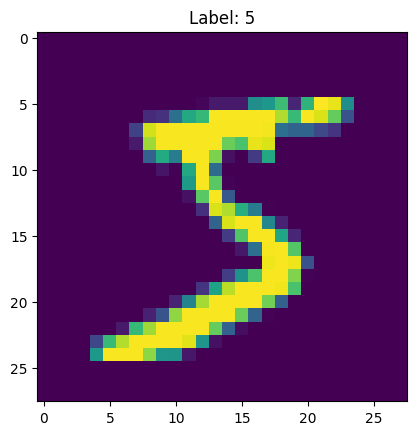

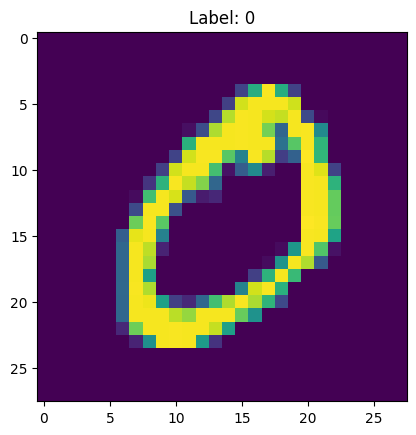

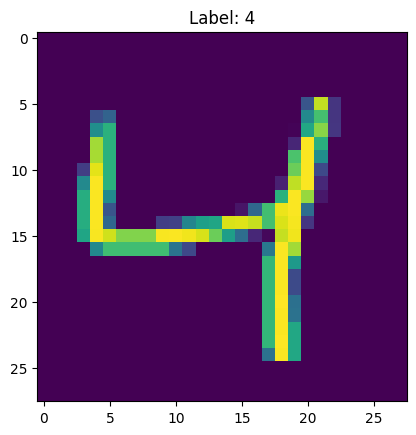

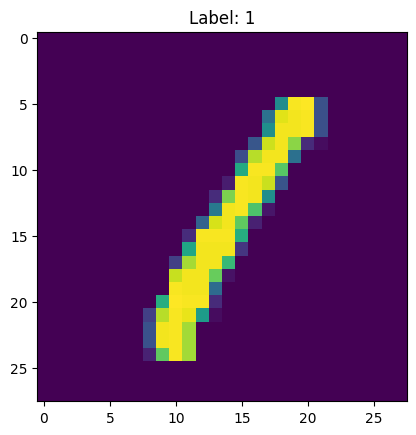

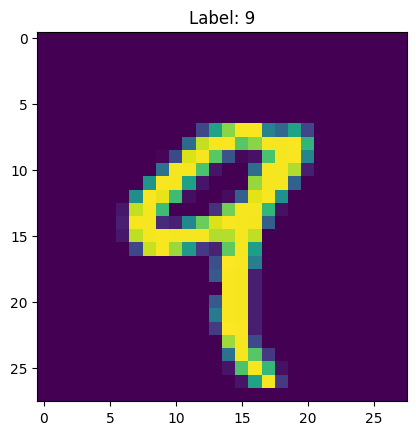

In [70]:
for i in range(0, 5):
  plt.imshow(X_train[i])
  plt.title(f'Label: {Y_train[i]}')
  plt.show()

### **Preprocessing Training Data**

In [71]:
X_train = X_train.reshape(X_train.shape[0], 784) # flattening images to a 1D vector
print(X_train.shape[0], X_train.shape[1]) 

60000 784


In [72]:
X_train = X_train / 255.0 # normalizing pixel values (to between 0 and 1)
X_train[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [73]:
# Defining a function for one hot encoding
def one_hot_encode(labels, num_classes):
    one_hot = np.zeros((labels.shape[0], num_classes))
    # Pseudo loop to set correct elements to 1
    one_hot[np.arange(labels.shape[0]), labels] = 1 
    return one_hot

In [74]:
# one-hot encoding Y for ease of use later
Y_train_one_hot = one_hot_encode(Y_train, 10) 

for i in range(0,5):
  print(f'{Y_train_one_hot[i]}\n')

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]



In [75]:
print(X_train.shape, Y_train_one_hot.shape) # should be (60000x784) & (60000x10)

(60000, 784) (60000, 10)


### **Defining a Neural Network Class (Feed Forward)**

In [76]:
class NeuralNetwork:
  def __init__(self, input_size, hidden_size, output_size):
    self.W1 = np.random.randn(input_size, hidden_size) 
    self.b1 = np.random.randn(1, hidden_size) 
    self.W2 = np.random.randn(hidden_size, output_size) 
    self.b2 = np.random.randn(1, output_size) 

  def ReLU(self, Z):
    return np.maximum(Z,0)

  def ReLU_derivative(self, Z):
    return Z > 0

  def softmax(self, Z):
    exp = np.exp(Z - np.max(Z)) # subtracting np.max(Z) for numerical stability
    return exp / np.sum(exp, axis=1, keepdims=True)
  
  def cross_entropy(self, y_true, y_pred):
    loss = -np.sum(y_true * np.log(y_pred))
    return loss / y_pred.shape[0]

  def forward_prop(self, X):
    self.Z1 = np.dot(X, self.W1) + self.b1
    self.A1 = self.ReLU(self.Z1)
    self.Z2 = np.dot(self.A1, self.W2) + self.b2
    # using softmax because it outputs a probalility distribution
    self.A2 = self.softmax(self.Z2) 
    return self.A2

  def backward_prop(self, X, Y):
    m = Y.shape[0] # batch size
    dZ2 = self.A2 - Y # cross entropy and softmax simplifies to this
    dW2 = np.dot(self.A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0) / m
    dZ1 = np.dot(dZ2, self.W2.T) * self.ReLU_derivative(self.Z1)
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0) / m
    return dW2, db2, dW1, db1

  def update_parameters(self, dW2, db2, dW1, db1, learning_rate):
    self.W1 -= learning_rate * dW1
    self.b1 -= learning_rate * db1
    self.W2 -= learning_rate * dW2
    self.b2 -= learning_rate * db2

  def train_network(self, X_train, Y_train, epochs, learning_rate, batch_size):
    for i in range(epochs):
      # Shuffle the dataset every epoch
      shuffled_indexes = np.random.permutation(X_train.shape[0])
      X_train_shuffled = X_train[shuffled_indexes]
      Y_train_shuffled = Y_train[shuffled_indexes]
     
      # Mini-batch gradient descent
      for j in range(0, X_train.shape[0], batch_size):
        # Extract mini-batches
        X_batch = X_train_shuffled[j:j+batch_size]
        Y_batch = Y_train_shuffled[j:j+batch_size]

        # Forward propagation
        A2 = self.forward_prop(X_batch)
        # Back propagation
        dW2, db2, dW1, db1 = self.backward_prop(X_batch, Y_batch)
        # Updating the parameters
        self.update_parameters(dW2, db2, dW1, db1, learning_rate)

      # Accuracy check
      if i % 10 == 0:
        print("Epoch: ", i)
        predictions = self.forward_prop(X_train)
        predicted_labels = np.argmax(predictions, axis=1)
        true_labels = np.argmax(Y_train, axis=1)
        accuracy = np.mean(predicted_labels == true_labels)
        print(predictions.shape, Y_train.shape, predicted_labels.shape, true_labels.shape)
        print("Accuracy: ", accuracy)

### **Creating and Training the Network**

In [77]:
NeuralNet = NeuralNetwork(784, 64, 10)

In [78]:
NeuralNet.train_network(X_train, Y_train_one_hot, 150, 0.01555, 30)

Epoch:  0
(60000, 10) (60000, 10) (60000,) (60000,)
Accuracy:  0.8139333333333333
Epoch:  10
(60000, 10) (60000, 10) (60000,) (60000,)
Accuracy:  0.8952
Epoch:  20
(60000, 10) (60000, 10) (60000,) (60000,)
Accuracy:  0.9146166666666666
Epoch:  30
(60000, 10) (60000, 10) (60000,) (60000,)
Accuracy:  0.9233833333333333
Epoch:  40
(60000, 10) (60000, 10) (60000,) (60000,)
Accuracy:  0.9310333333333334
Epoch:  50
(60000, 10) (60000, 10) (60000,) (60000,)
Accuracy:  0.93505
Epoch:  60
(60000, 10) (60000, 10) (60000,) (60000,)
Accuracy:  0.9409166666666666
Epoch:  70
(60000, 10) (60000, 10) (60000,) (60000,)
Accuracy:  0.9430833333333334
Epoch:  80
(60000, 10) (60000, 10) (60000,) (60000,)
Accuracy:  0.9491
Epoch:  90
(60000, 10) (60000, 10) (60000,) (60000,)
Accuracy:  0.9509166666666666
Epoch:  100
(60000, 10) (60000, 10) (60000,) (60000,)
Accuracy:  0.9514333333333334
Epoch:  110
(60000, 10) (60000, 10) (60000,) (60000,)
Accuracy:  0.9537833333333333
Epoch:  120
(60000, 10) (60000, 10) (6

### **Preprocessing the Test Data**

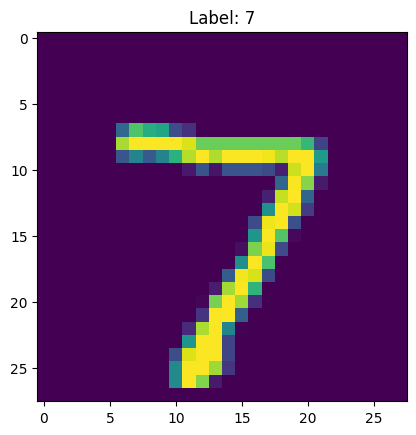

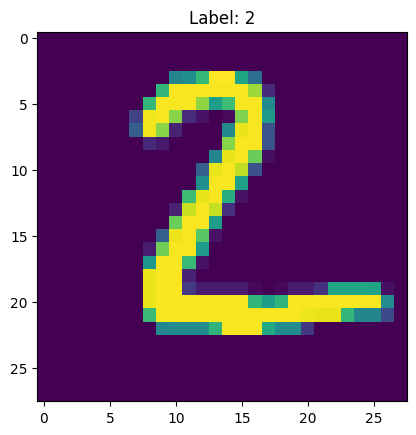

In [79]:
for i in range(0, 2):
  plt.imshow(X_test[i])
  plt.title(f'Label: {Y_test[i]}')
  plt.show()

In [80]:
X_test = X_test.reshape(X_test.shape[0], 784) # flattening images to a 1D vector
print(X_test.shape[0], X_test.shape[1])

10000 784


In [81]:
X_test = X_test / 255.0 # normalizing pixel values to between 0 and 1
X_test[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [64]:
Y_test_one_hot = one_hot_encode(Y_test, 10)
Y_test_one_hot.shape

(10000, 10)

### **Classifying Images From the Test Set**

In [82]:
preds = NeuralNet.forward_prop(X_test) # making predictions on test set

In [83]:
# Outputting results
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(Y_test_one_hot, axis=1)
accuracy_val = np.mean(pred_labels == true_labels)
print("Accuracy: ", accuracy_val)

Accuracy:  0.9517
